# CNN Interpretation - Image Generation

Note: This notebook is desinged to run with GPU runtime.

####[CII-01]
Import modules and set a random seed.

In [ ]:
import os, random
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, saving

random.seed(20230515)
np.random.seed(20190225)
tf.random.set_seed(20190225)

####[CII-02]
Define a function to generate random images that maximize the outputs from filters.

In [ ]:
def gen_pattern(filter_ouput_model, filter_index):
    input_image = normal(0.5, 0.1, 28*28).reshape([1, 28*28])
    input_image = tf.convert_to_tensor(input_image, dtype=tf.float32)

    epsilon = 1000
    for _ in range(20):
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            filter_outputs = filter_ouput_model(input_image)
            mean_output = tf.reduce_mean(filter_outputs[0][:, :, filter_index])
        grads = tape.gradient(mean_output, input_image)
        input_image += epsilon * grads
        epsilon *= 0.9

    input_image = input_image.numpy()
    image = input_image[0]
    image -= np.min(image)
    image /= np.max(image)
    return image

####[CII-03]
Define a model with fixed filters.

In [ ]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0

    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

model = models.Sequential()
model.add(layers.Input(shape=(28*28,), name='input'))
model.add(layers.Reshape((28, 28, 1), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter (Conv2D)                 │ (None, 28, 28, 2)           │              50 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ abs (Lambda)                         │ (None, 28, 28, 2)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cut_off (Lambda)                     │ (None, 28, 28, 2)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50 (200.00 B)

 Trainable params: 50 (200.00 B)

 Non-trainable params: 0 (0.00 B)

####[CII-04]
Generate images that maximize the outputs from the fixed filters.

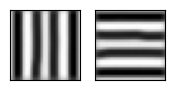

In [ ]:
fig = plt.figure(figsize=(2, 1))

for i in range(model.outputs[0].shape[-1]):
    img = gen_pattern(model, i)
    subplot = fig.add_subplot(1, 2, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)

####[CII-05]
Mount your Google Drive on `/content/gdrive`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####[CII-06]
Confirm that the exported model file `MNIST_double.keras` is on your Google Drive.

In [ ]:
!ls -lh '/content/gdrive/My Drive/MNIST_double.keras'

-rw------- 1 root root 38M Feb 16 03:51 '/content/gdrive/My Drive/MNIST_double.keras'


####[CII-07]
Restore the model from the exported model file.

In [ ]:
cnn_model = saving.load_model('/content/gdrive/My Drive/MNIST_double.keras')
cnn_model.summary()

Model: "CNN_double_layer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter1 (Conv2D)                │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1 (MaxPooling2D)          │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_filter2 (Conv2D)                │ (None, 14, 14, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2 (MaxPooling2D)          │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 1024)                │       3,212,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,823,904 (37.48 MB)

 Trainable params: 3,274,634 (12.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,549,270 (24.98 MB)

####[CII-08]
Generate images that maximize the outputs from the first filters.

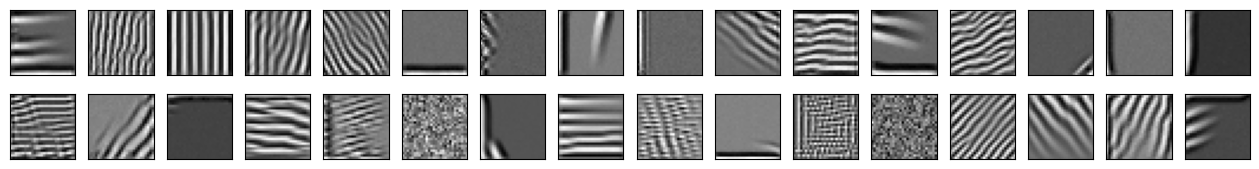

In [ ]:
fig = plt.figure(figsize=(16, 2))
layer_output = cnn_model.get_layer('conv_filter1').output
filter_output_model = models.Model(cnn_model.inputs[0], layer_output)

for i in range(filter_output_model.outputs[0].shape[-1]):
    img = gen_pattern(filter_output_model, i)
    subplot = fig.add_subplot(2, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)

####[CII-09]
Generate images that maximize the outputs from the second filters.

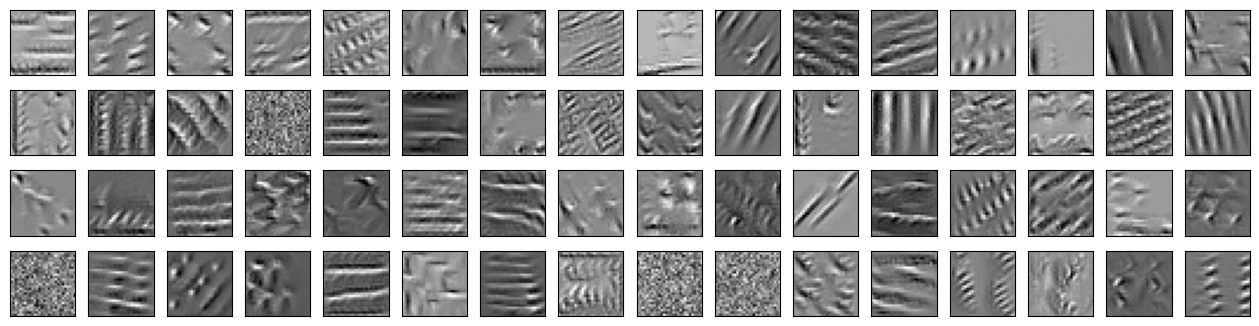

In [ ]:
fig = plt.figure(figsize=(16, 4))
layer_output = cnn_model.get_layer('conv_filter2').output
filter_output_model = models.Model(cnn_model.inputs[0], layer_output)

for i in range(filter_output_model.outputs[0].shape[-1]):
    img = gen_pattern(filter_output_model, i)
    subplot = fig.add_subplot(4, 16, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(img.reshape(28, 28), cmap=plt.cm.gray_r)